# Section 5.4 — Bayesian difference between means

This notebook contains the code examples from [Section 5.4 Bayesian difference between means]() from the **No Bullshit Guide to Statistics**.

See also:
- [Half_a_dozen_dmeans_in_Bambi.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/Half_a_dozen_dmeans_in_Bambi.ipynb)
- [compare_iqs2_many_ways.ipynb](./explorations/compare_iqs2_many_ways.ipynb)
- [t-test.ipynb](./explorations/bambi/t-test.ipynb)
- Examples: https://github.com/treszkai/best/tree/master/examples
- Links: https://www.one-tab.com/page/HoSHco_iSG-MHXG7kXOj7g


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
from ministats.utils import savefigure
DESTDIR = "figures/bayes/dmeans"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Introduciton

We'll now  revisit the problem of comparison between two groups from a Bayesian perspective.

## Model

The data models for the two groups are based on Student’s $t$-distribution:

$$
    X \sim \mathcal{T}(\nu, M_X, \Sigma_X)
    \qquad
    \text{and}
    \qquad
    Y \sim \mathcal{T}(\nu, M_Y, \Sigma_Y).
$$

We'll use a normal prior for the means,
half-$t$ priors for standard deviations,
and a gamma distribution for the degrees of freedom parameter:

$$
    M_X, M_Y \sim \mathcal{N}(\mu_{M}, \sigma_{M}),
    \quad
    \Sigma_X, \Sigma_Y \sim \mathcal{T}^+\!(\nu_{\Sigma}, \sigma_{\Sigma}),
    \quad
    \nu \sim \textrm{Gamma}(\alpha,\beta).
$$


### Bambi formula objects

In [4]:
import bambi as bmb
formula = bmb.Formula("y ~ 0 + group",
                      "sigma ~ 0 + group")
formula

Formula('y ~ 0 + group', 'sigma ~ 0 + group')

In [5]:
formula.main, formula.additionals

('y ~ 0 + group', ('sigma ~ 0 + group',))

In [6]:
formula.get_all_formulas()

['y ~ 0 + group', 'sigma ~ 0 + group']

### Choosing priors for log-sigma

#### Normal distribution for log-sigma


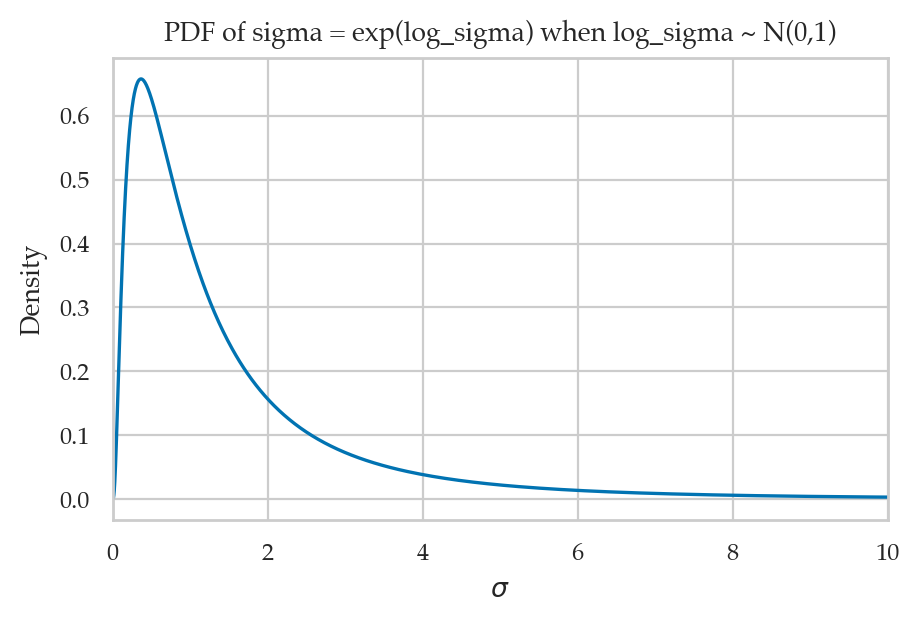

In [7]:
from scipy.stats import norm

logsig = np.linspace(-5, 5, 1000)
density_logsig = norm(0,1).pdf(logsig)
# sns.lineplot(x=logsig, y=density_logsig)

sigma = np.exp(logsig)

# Apply the change of variables to get the density for sigma
# based on the Jacobian adjustment |d(log(sigma))/d(sigma)| = 1/sigma
density_sigma = density_logsig / sigma  

# Plot the transformed density using seaborn
ax = sns.lineplot(x=sigma, y=density_sigma)
ax.set_xlabel('$\\sigma$')
ax.set_ylabel('Density')
ax.set_title('PDF of sigma = exp(log_sigma) when log_sigma ~ N(0,1)')
ax.set_xlim(0, 10);

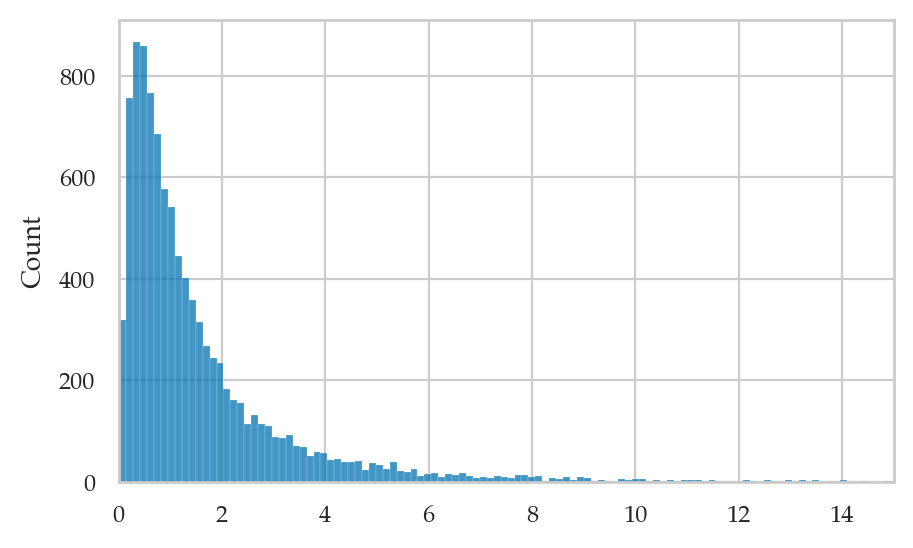

In [8]:
# verify using sampling
N = 10000
logsigs = norm(0,1).rvs(N)
sigs = np.exp(logsigs)
ax = sns.histplot(sigs)
ax.set_xlim(0, 15);

### Gumbel distribution?

In [9]:
# from scipy.stats import gumbel_r, expon
# N = 1000
# gumbels = gumbel_r(loc=1.609, scale=1).rvs(N)
# exp_gumbels = np.exp(gumbels)
# exps = expon(loc=0, scale=5).rvs(N)
# ax = sns.histplot(exp_gumbels, alpha=0.2, stat="density", label="expgumbel")
# sns.histplot(exps, alpha=0.2, stat="density", ax=ax, label="exp")
# ax.set_xlim(0, 40);
# ax.legend();

### Choosing priors for the degrees of freedom parameter

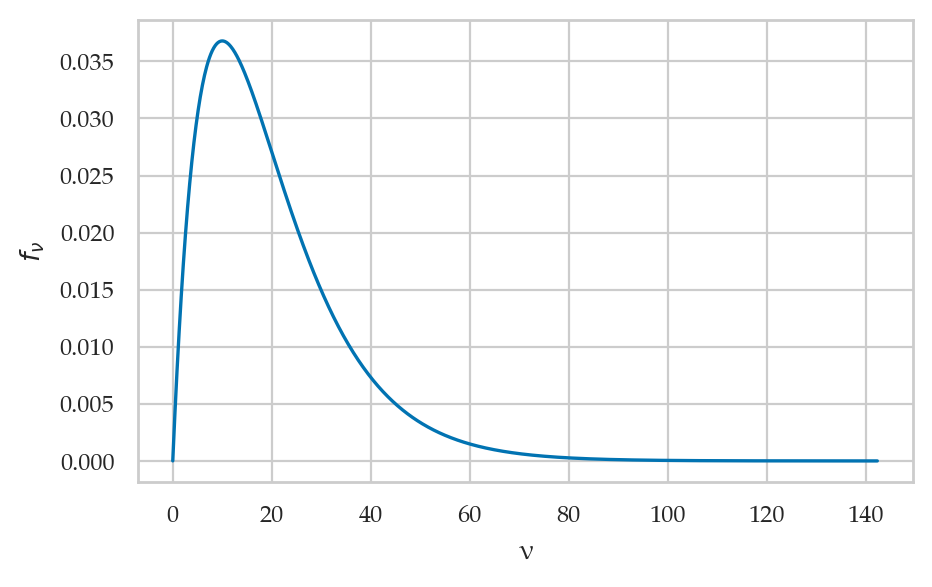

In [10]:
from scipy.stats import gamma
from ministats import plot_pdf

alpha, beta = 2, 0.1
rv_nu = gamma(a=2, scale=1/beta)
plot_pdf(rv_nu, rv_name="ν");

In [11]:
# # FIGURES ONLY
# from scipy.stats import gamma
# from scipy.stats import norm
# from ministats import plot_pdf

# with plt.rc_context({"figure.figsize":(6,2.2)}):
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#
#     # log(sigma) ~ N(0,1)
#     logsig = np.linspace(-5, 5, 1000)
#     density_logsig = norm(0,1).pdf(logsig)
#     sigma = np.exp(logsig)
#     density_sigma = density_logsig / sigma
#     sns.lineplot(x=sigma, y=density_sigma, ax=ax1)
#     ax1.set_xlabel('$\\sigma$')
#     ax1.set_ylabel('$f_{\\Sigma}$')
#     ax1.set_title("(a) log($\\sigma$) ~ $\\mathcal{N}$(0,1)")
#     ax1.set_xlim(-0.2, 10);
#
#     # nu ~ Gamma(2,0.1)
#     alpha, beta = 2, 0.1
#     rv_nu = gamma(a=2, scale=1/beta)
#     plot_pdf(rv_nu, rv_name="ν", ax=ax2)
#     ax2.set_title('(b) $\\nu$ ~ Gamma(2,0.1)')
#     ax2.set_ylabel('$f_{\\nu}$')
#     ax2.set_xlim(-1, 75);
#
#     filename = os.path.join(DESTDIR, "log_sigma_normal_and_gamma_priors.pdf")
#     savefigure(fig, filename)

## Example 1: comparing electricity prices

Electricity prices from East End and West End

### Electricity prices dataset

In [12]:
eprices = pd.read_csv("../datasets/eprices.csv")
print(eprices.groupby("loc")["price"].describe())

      count      mean       std  min  25%  50%   75%   max
loc                                                       
East    9.0  6.155556  0.877655  4.8  5.5  6.3   6.5   7.7
West    9.0  9.155556  1.562139  6.8  8.3  8.6  10.0  11.8


In [13]:
eprices["price"].mean(), eprices["price"].std()

(7.655555555555556, 1.973120020267162)

### Bayesian model


\begin{align*}
    X_W \sim \mathcal{T}(\nu, M_W, \Sigma_W),
    \qquad  \qquad
    X_E \sim \mathcal{T}(\nu, M_E, \Sigma_E), \qquad\qquad \\
    M_W, M_E \!\sim\! \mathcal{N}(\mu_{M}, \sigma_{M}),
    \quad
    \log\Sigma_W, \log\Sigma_E\!\sim\!\mathcal{N}(0,1),
    \quad
    \nu \!\sim\! \text{Gamma}(2,0.1).
\end{align*}

### Bambi model


In [14]:
formula1 = bmb.Formula("price ~ 0 + loc",
                       "sigma ~ 0 + loc")
#######################################################
priors1 = {
    "loc": bmb.Prior("Normal", mu=8, sigma=5),
    "sigma": {
        "loc": bmb.Prior("Normal", mu=0, sigma=1)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}

mod1 = bmb.Model(formula=formula1,
                 family="t",
                 link="identity",
                 priors=priors1,
                 data=eprices)
mod1

       Formula: price ~ 0 + loc
                sigma ~ 0 + loc
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 18
        Priors: 
    target = mu
        Common-level effects
            loc ~ Normal(mu: 8.0, sigma: 5.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_loc ~ Normal(mu: 0.0, sigma: 1.0)

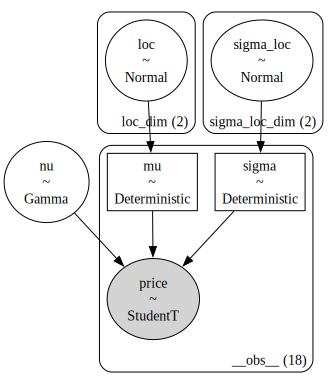

In [15]:
mod1.build()
mod1.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example1_eprices_mod1_graph")
# mod1.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [16]:
idata1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, loc, sigma_loc]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Processing the results

Calculate derived quantities used for the analysis plots and summaries.

In [17]:
post1 = idata1["posterior"]

# Calculate the difference between between means
post1["mu_East"] = post1["loc"].sel(loc_dim="East")
post1["mu_West"] = post1["loc"].sel(loc_dim="West")
post1["dmeans"] = post1["mu_West"] - post1["mu_East"]

# Calculate sigmas from log-sigmas
#######################################################
logsig_E = post1["sigma_loc"].sel(sigma_loc_dim="East")
logsig_W = post1["sigma_loc"].sel(sigma_loc_dim="West")
post1["sigma_East"] = np.exp(logsig_E)
post1["sigma_West"] = np.exp(logsig_W)

# Calculate the difference between standard deviations
post1["dstd"] = post1["sigma_West"]-post1["sigma_East"]

# Effect size
#######################################################
pvar =(post1["sigma_West"]**2+post1["sigma_East"]**2)/2
post1["cohend"] = post1["dmeans"] / np.sqrt(pvar)

In [18]:
# #ALT: use helper function
# from ministats import calc_dmeans_stats
# calc_dmeans_stats(idata1, group_name="loc")

In [59]:
az.summary(idata1, kind="stats", hdi_prob=0.95,
           var_names=["mu_West", "mu_East", "dmeans", "sigma_West", "sigma_East", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
mu_West,9.093,0.552,7.969,10.147
mu_East,6.154,0.327,5.516,6.803
dmeans,2.939,0.641,1.772,4.294
sigma_West,1.566,0.458,0.837,2.500
sigma_East,0.913,0.260,0.466,1.412
dstd,0.653,0.528,-0.320,1.764
nu,21.261,14.249,1.673,48.803
cohend,2.372,0.708,1.021,3.771


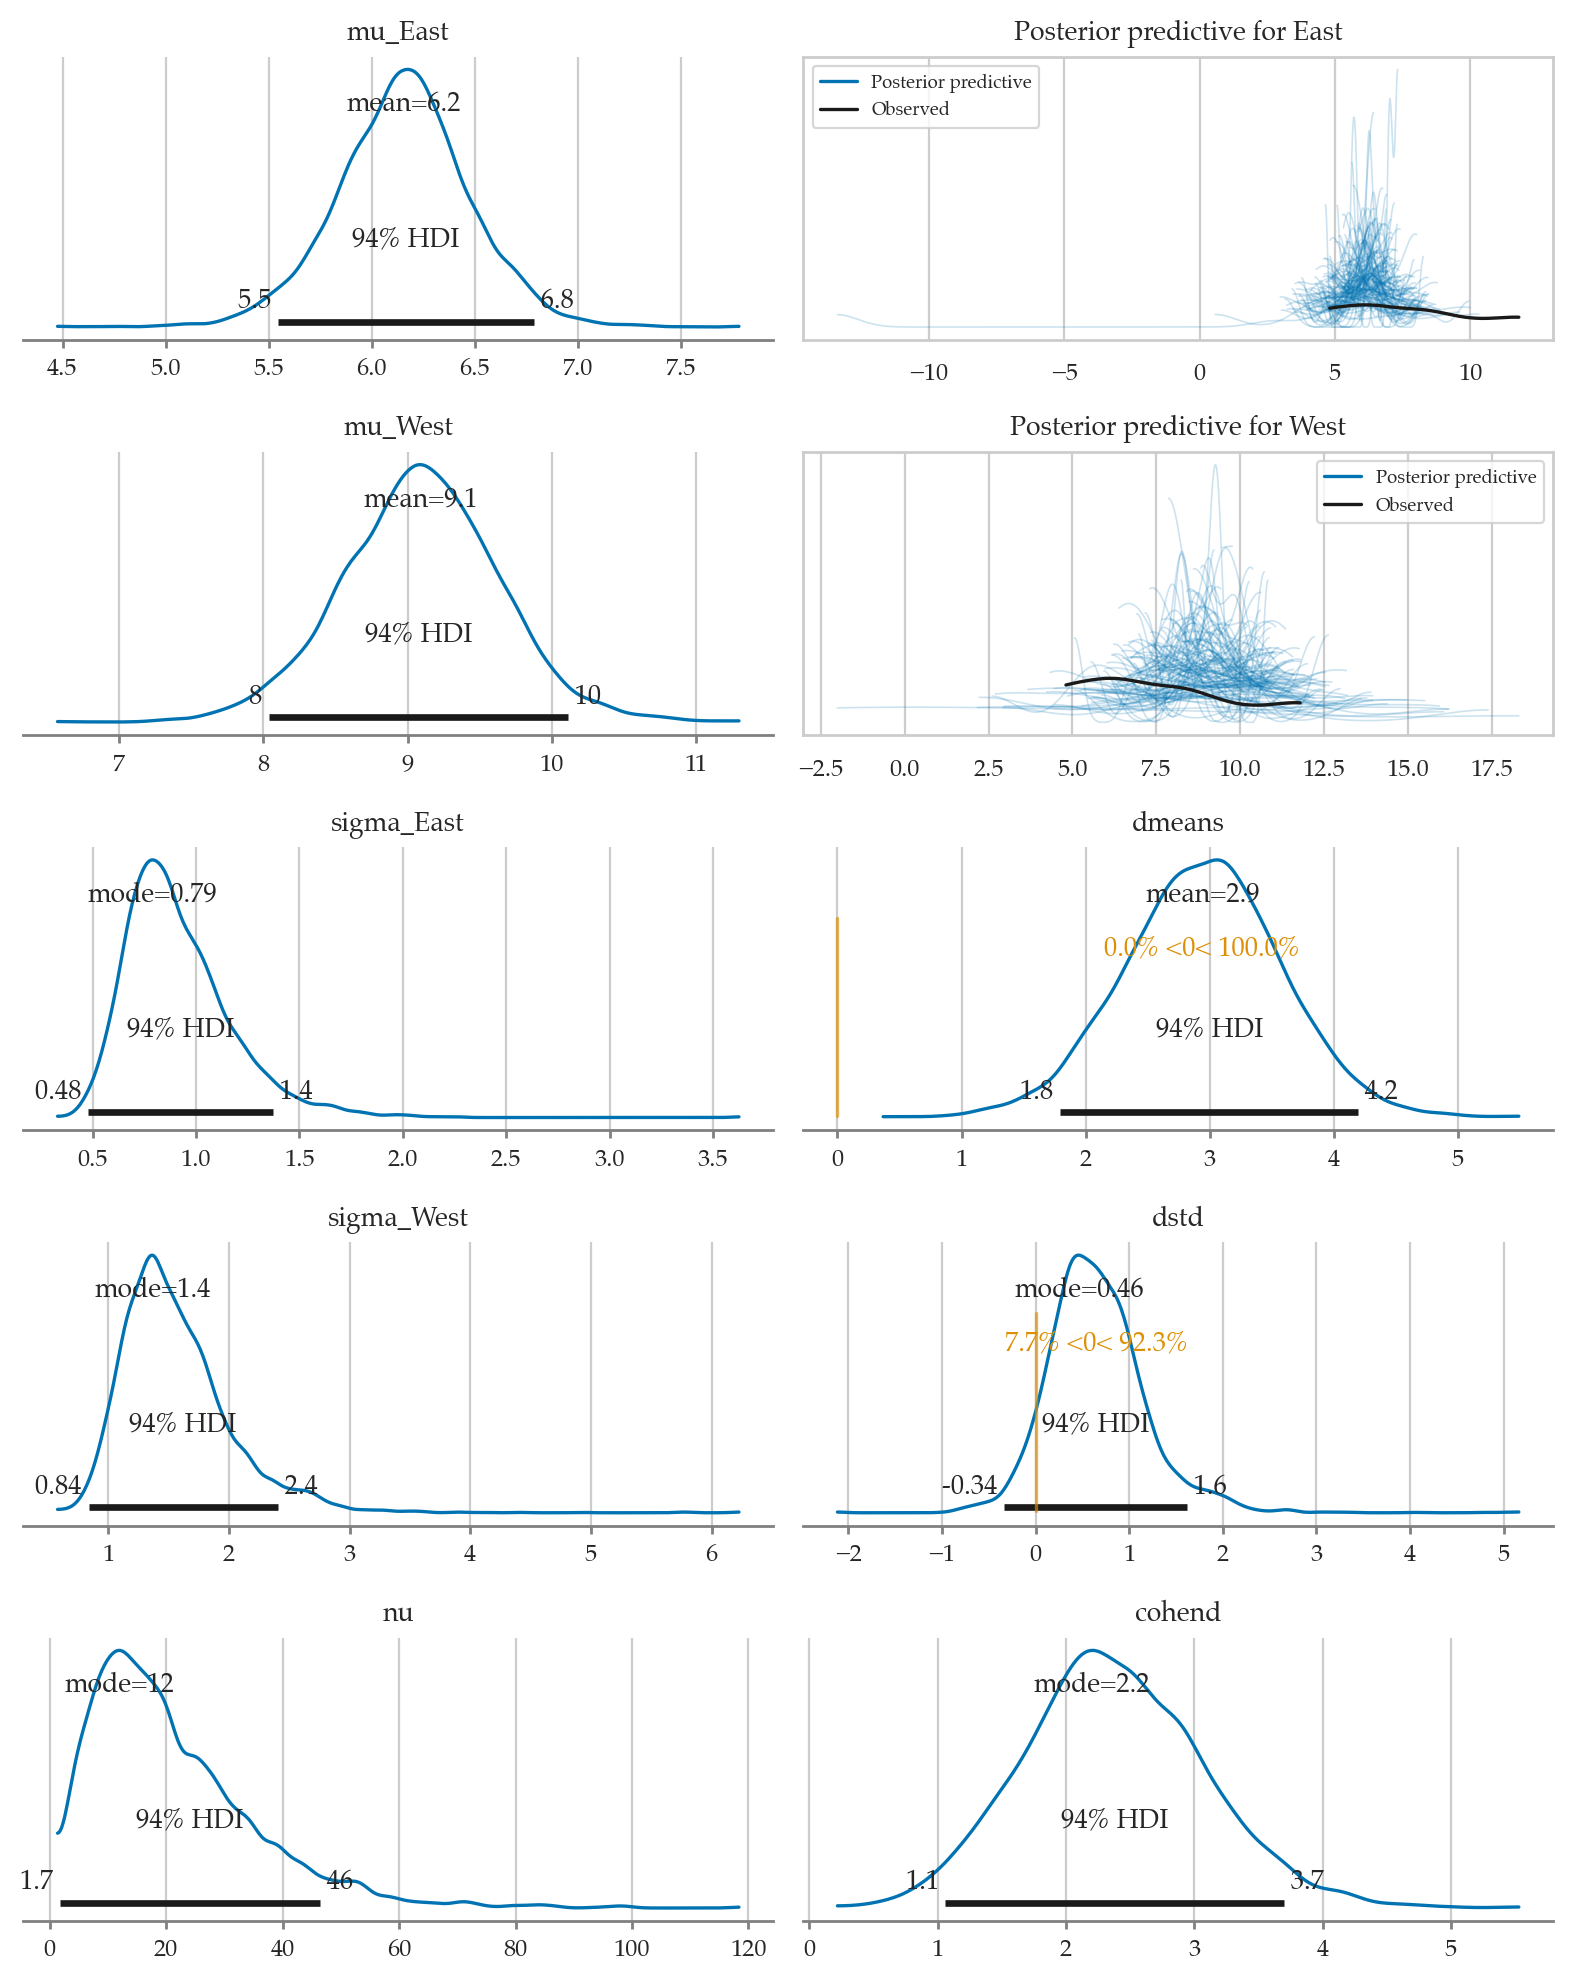

In [20]:
from ministats import plot_dmeans_stats
plot_dmeans_stats(mod1, idata1, group_name="loc");

In [21]:
# # FIGURES ONLY
# from ministats import plot_dmeans_stats
# plot_dmeans_stats(mod1, idata1, group_name="loc",
#                   ppc_xlims=[2,15], figsize=(6,6.5));
# filename = os.path.join(DESTDIR, "example1_dmeans_plots.pdf")
# savefigure(plt.gcf(), filename)

### Compare to frequentist results

In [22]:
from scipy.stats import ttest_ind
pricesW = eprices[eprices["loc"]=="West"]["price"]
pricesE = eprices[eprices["loc"]=="East"]["price"]

res1 = ttest_ind(pricesW, pricesE, equal_var=False)
res1.statistic, res1.pvalue, res1.df

(5.022875513276464, 0.00025703383372176116, 12.592817027231032)

In [23]:
from ministats import cohend2
cohend2(pricesW, pricesE)

2.3678062243290996

### Conclusions

## Example 2: lecture and debate curriculums

### Students dataset

In [63]:
students = pd.read_csv("../datasets/students.csv")
print(students.groupby("curriculum")["score"].describe().round(2))

            count   mean    std   min    25%    50%    75%   max
curriculum                                                      
debate        8.0  76.46  10.52  62.9  69.55  75.55  80.92  96.2
lecture       7.0  68.14   7.76  57.0  63.30  70.30  73.85  75.4


### Bayesian model
TODO: add formulas

### Bambi model

In [66]:
formula2 = bmb.Formula("score ~ 0 + curriculum",
                       "sigma ~ 0 + curriculum")

#######################################################
priors2 = {
    "curriculum": bmb.Prior("Normal", mu=70, sigma=30),
    "sigma": {
        "curriculum":bmb.Prior("Normal", mu=0, sigma=1)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}

mod2 = bmb.Model(formula=formula2,
                 family="t",
                 link="identity",
                 priors=priors2,
                 data=students)
mod2

       Formula: score ~ 0 + curriculum
                sigma ~ 0 + curriculum
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 15
        Priors: 
    target = mu
        Common-level effects
            curriculum ~ Normal(mu: 70.0, sigma: 30.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_curriculum ~ Normal(mu: 0.0, sigma: 1.0)

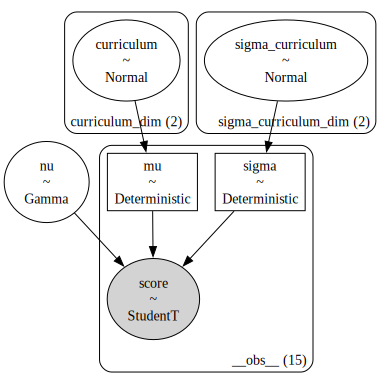

In [67]:
mod2.build()
mod2.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example2_students_mod2_graph")
# mod2.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [68]:
idata2 = mod2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, curriculum, sigma_curriculum]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [74]:
#######################################################
from ministats import calc_dmeans_stats
calc_dmeans_stats(idata2, group_name="curriculum")
az.summary(idata2, kind="stats", hdi_prob=0.95,
           var_names=["mu_debate", "mu_lecture", "dmeans", "sigma_debate",
                      "sigma_lecture", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
mu_debate,75.824,3.516,68.839,82.889
mu_lecture,68.913,2.914,63.334,74.748
dmeans,-6.911,4.593,-16.076,1.848
sigma_debate,8.705,2.695,3.669,14.046
sigma_lecture,6.585,2.141,2.572,11.041
dstd,-2.120,3.209,-8.510,4.061
nu,16.955,13.529,0.749,43.406
cohend,-0.910,0.606,-2.072,0.282


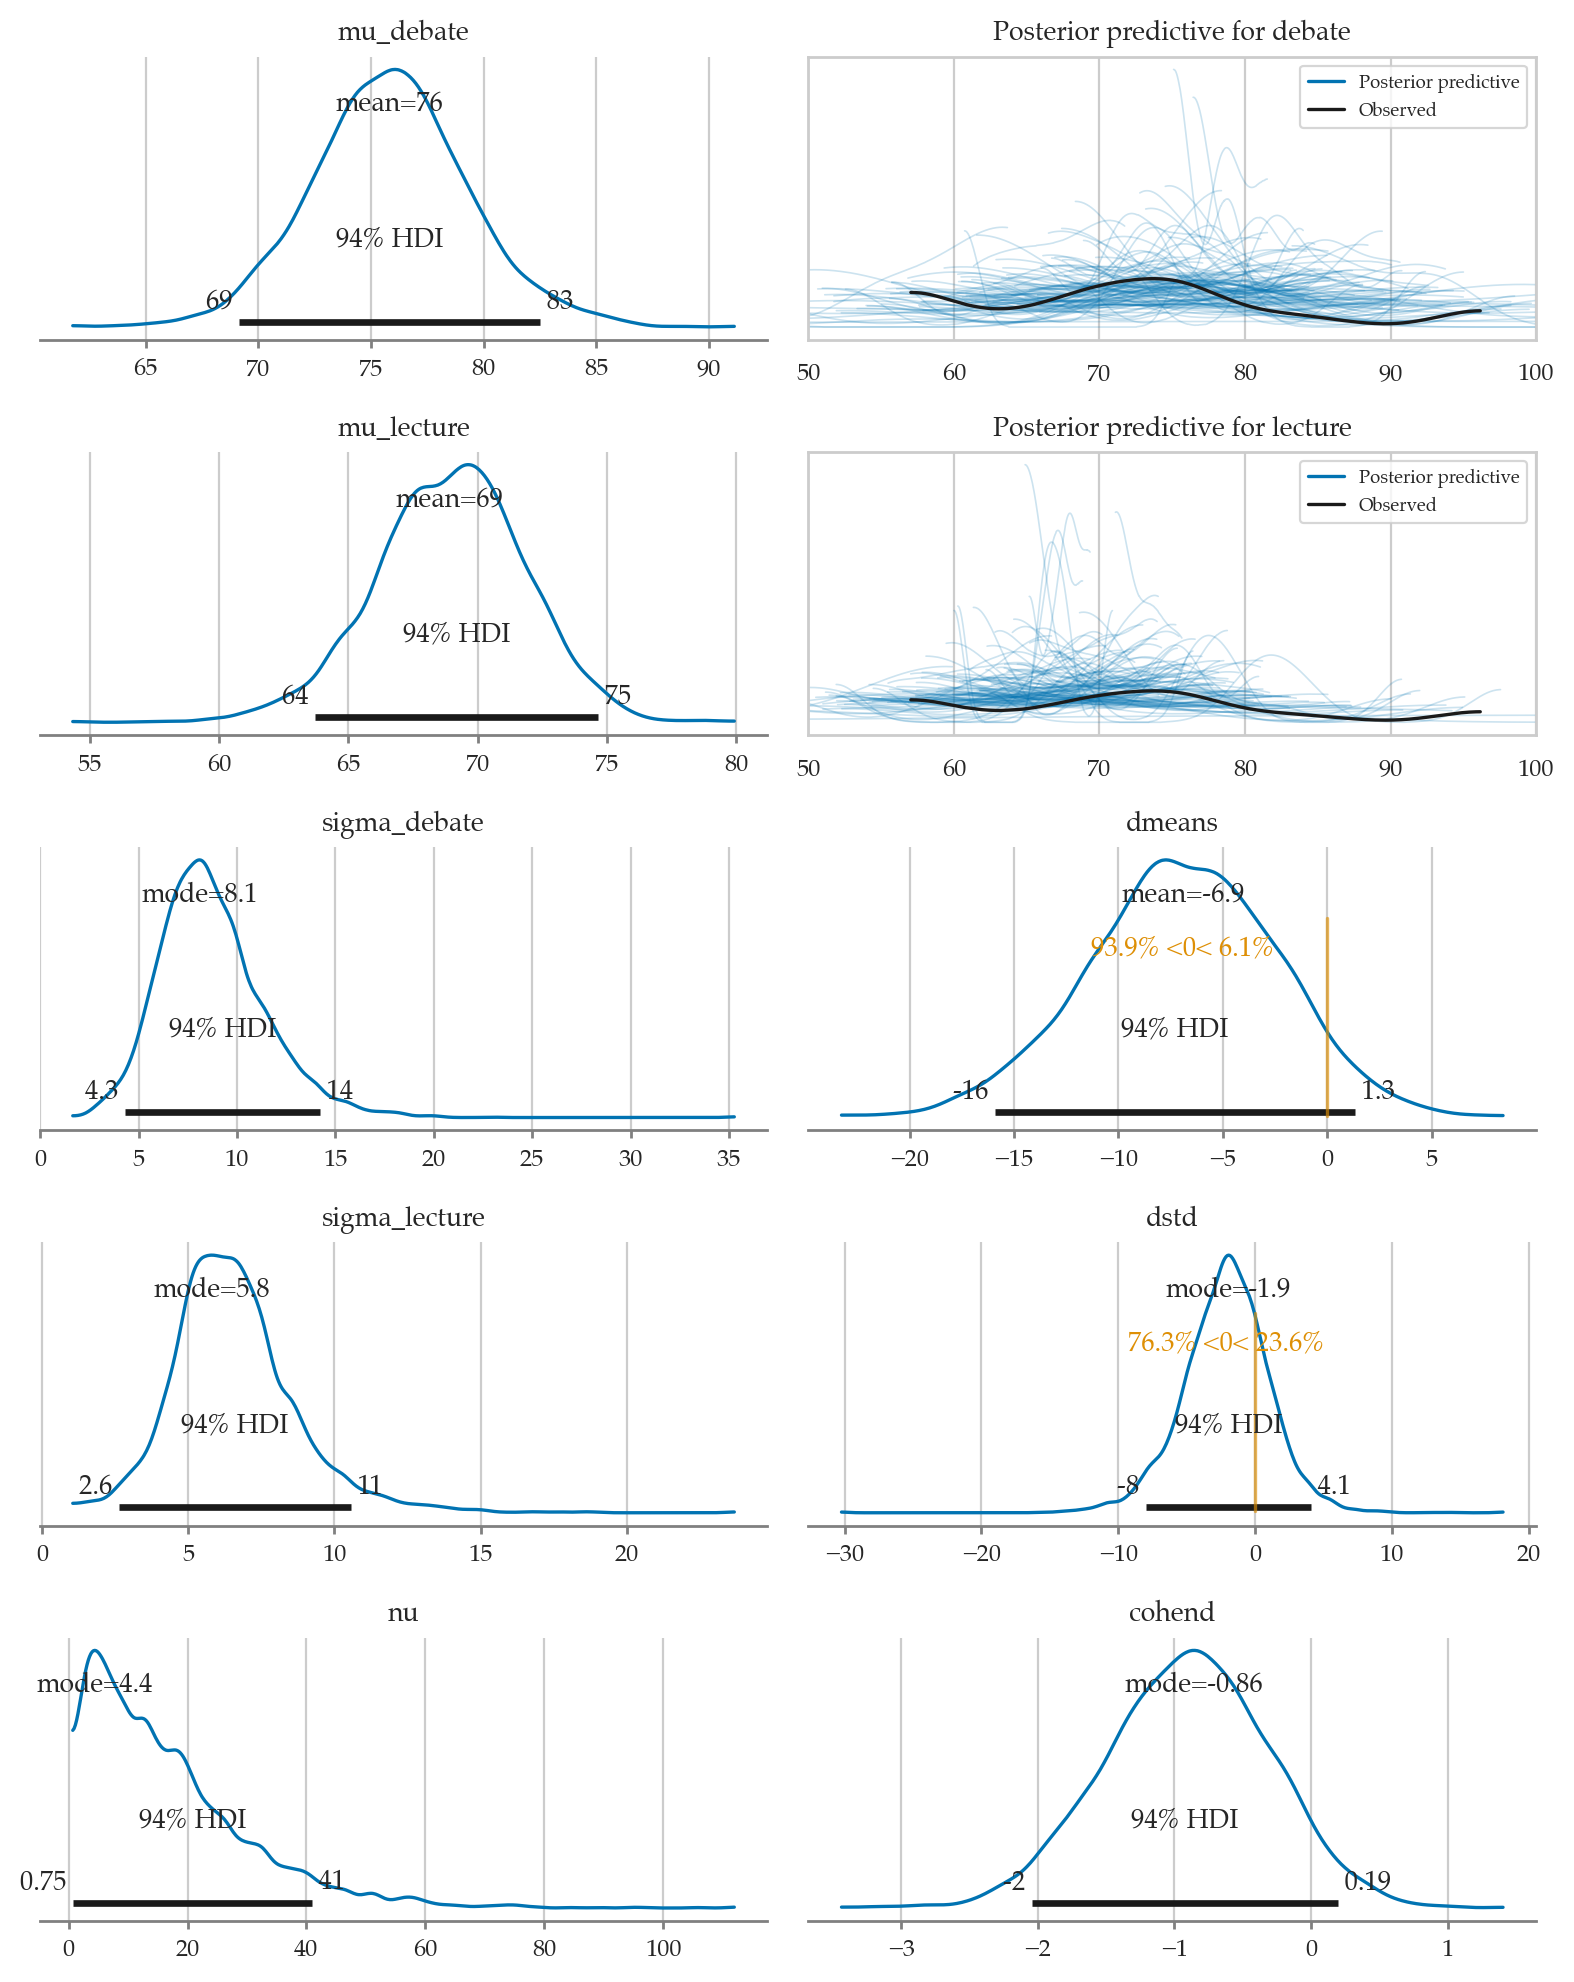

In [70]:
#######################################################
from ministats import plot_dmeans_stats
plot_dmeans_stats(mod2, idata2, ppc_xlims=[50,100], group_name="curriculum");

Saved figure to figures/bayes/dmeans/example2_dmeans_plots.pdf
Saved figure to figures/bayes/dmeans/example2_dmeans_plots.png


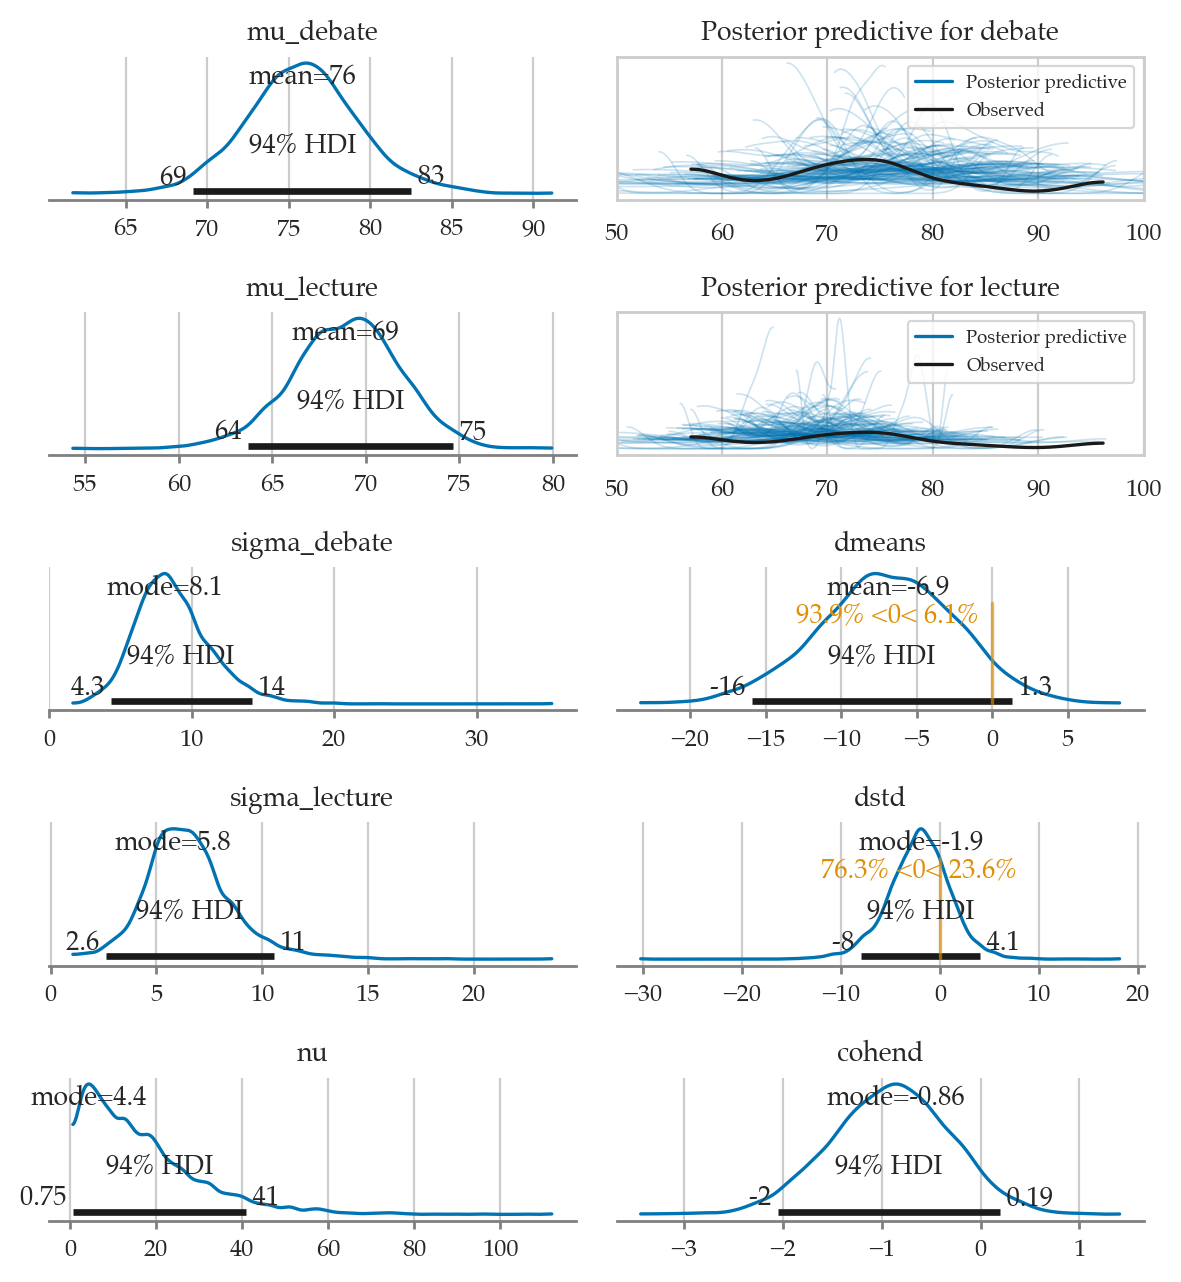

In [76]:
# # FIGURES ONLY
# from ministats import plot_dmeans_stats
# plot_dmeans_stats(mod2, idata2, group_name="curriculum",
#                   ppc_xlims=[50,100], figsize=(6,6.5));
# filename = os.path.join(DESTDIR, "example2_dmeans_plots.pdf")
# savefigure(plt.gcf(), filename)

### Compare to frequentist results

In [75]:
from scipy.stats import ttest_ind
#######################################################
studentsD = students[students["curriculum"]=="debate"]
studentsL = students[students["curriculum"]=="lecture"]
scoresD = studentsD["score"]
scoresL = studentsL["score"]

scoresD = students[students["curriculum"]=="debate"]["score"]
scoresL = students[students["curriculum"]=="lecture"]["score"]

res2 = ttest_ind(scoresD, scoresL, equal_var=False)
res2.statistic, res2.pvalue

(1.756598395925055, 0.10307495448387388)

In [32]:
from ministats import cohend2
cohend2(scoresD, scoresL)

0.8900742000749484

### Conclusions

## Example 3: comparing IQ scores

We'll look at IQ scores data taken from a the paper *Bayesian Estimation Supersedes the t-Test* (BEST) by John K. Kruschke.

smart drug administered to `treatment` group and want to compare to `control` group. Data contains outliers)

cf. [compare_iqs2_many_ways.ipynb](./explorations/compare_iqs2_many_ways.ipynb)

### IQ scores dataset

In [80]:
iqs2 = pd.read_csv("../datasets/exercises/iqs2.csv")
iqs2.groupby("group")["iq"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,42.0,100.357143,2.516496,88.0,100.0,100.5,101.0,105.0
treat,47.0,101.914894,6.021085,82.0,100.0,102.0,103.0,124.0


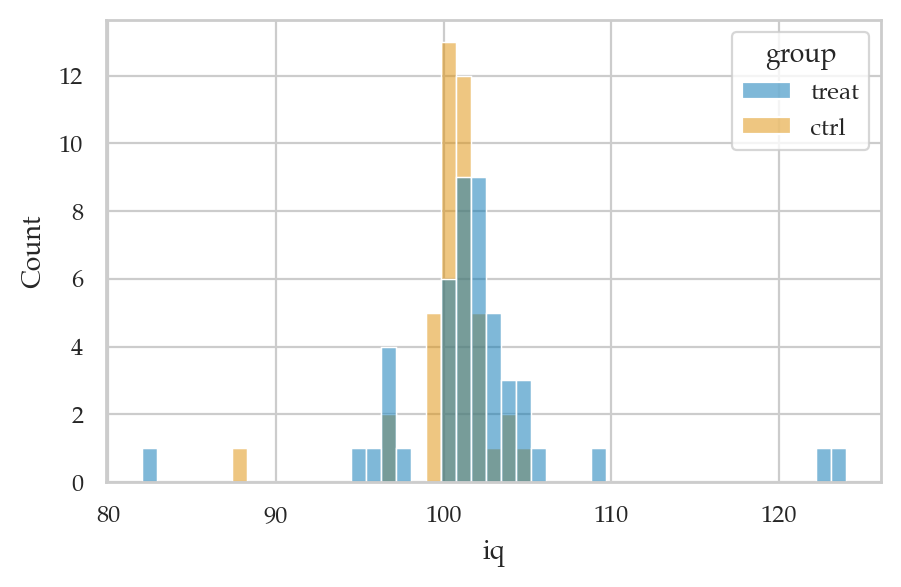

In [34]:
sns.histplot(data=iqs2, x="iq", hue="group");

### Bayesian model
TODO: add formulas

### Bambi model

In [35]:
formula3 = bmb.Formula("iq ~ 0 + group",
                       "sigma ~ 0 + group")

priors3 = {
    "group": bmb.Prior("Normal", mu=100, sigma=35),
    "sigma": {
        "group": bmb.Prior("Normal", mu=0, sigma=1)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}


mod3 = bmb.Model(formula=formula3,
                 family="t",
                 link="identity",
                 priors=priors3,
                 data=iqs2)

mod3

       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: 100.0, sigma: 35.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)

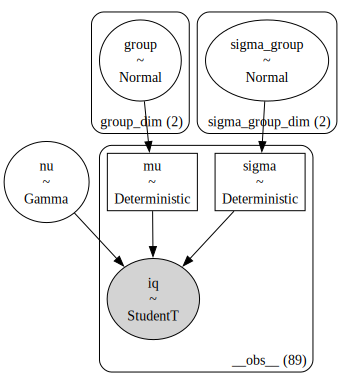

In [36]:
mod3.build()
mod3.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example3_iqs_mod3_graph")
# mod3.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [37]:
idata3 = mod3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [90]:
from ministats import calc_dmeans_stats
calc_dmeans_stats(idata3, group_name="group");
az.summary(idata3, kind="stats", hdi_prob=0.95,
           var_names=["mu_treat", "mu_ctrl", "dmeans", "sigma_treat", "sigma_ctrl", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
mu_treat,101.551,0.362,100.808,102.241
mu_ctrl,100.522,0.210,100.111,100.921
dmeans,1.028,0.422,0.221,1.862
sigma_treat,1.940,0.407,1.207,2.745
sigma_ctrl,1.012,0.201,0.652,1.413
dstd,0.928,0.410,0.180,1.763
nu,1.817,0.484,0.981,2.760
cohend,0.683,0.302,0.120,1.284


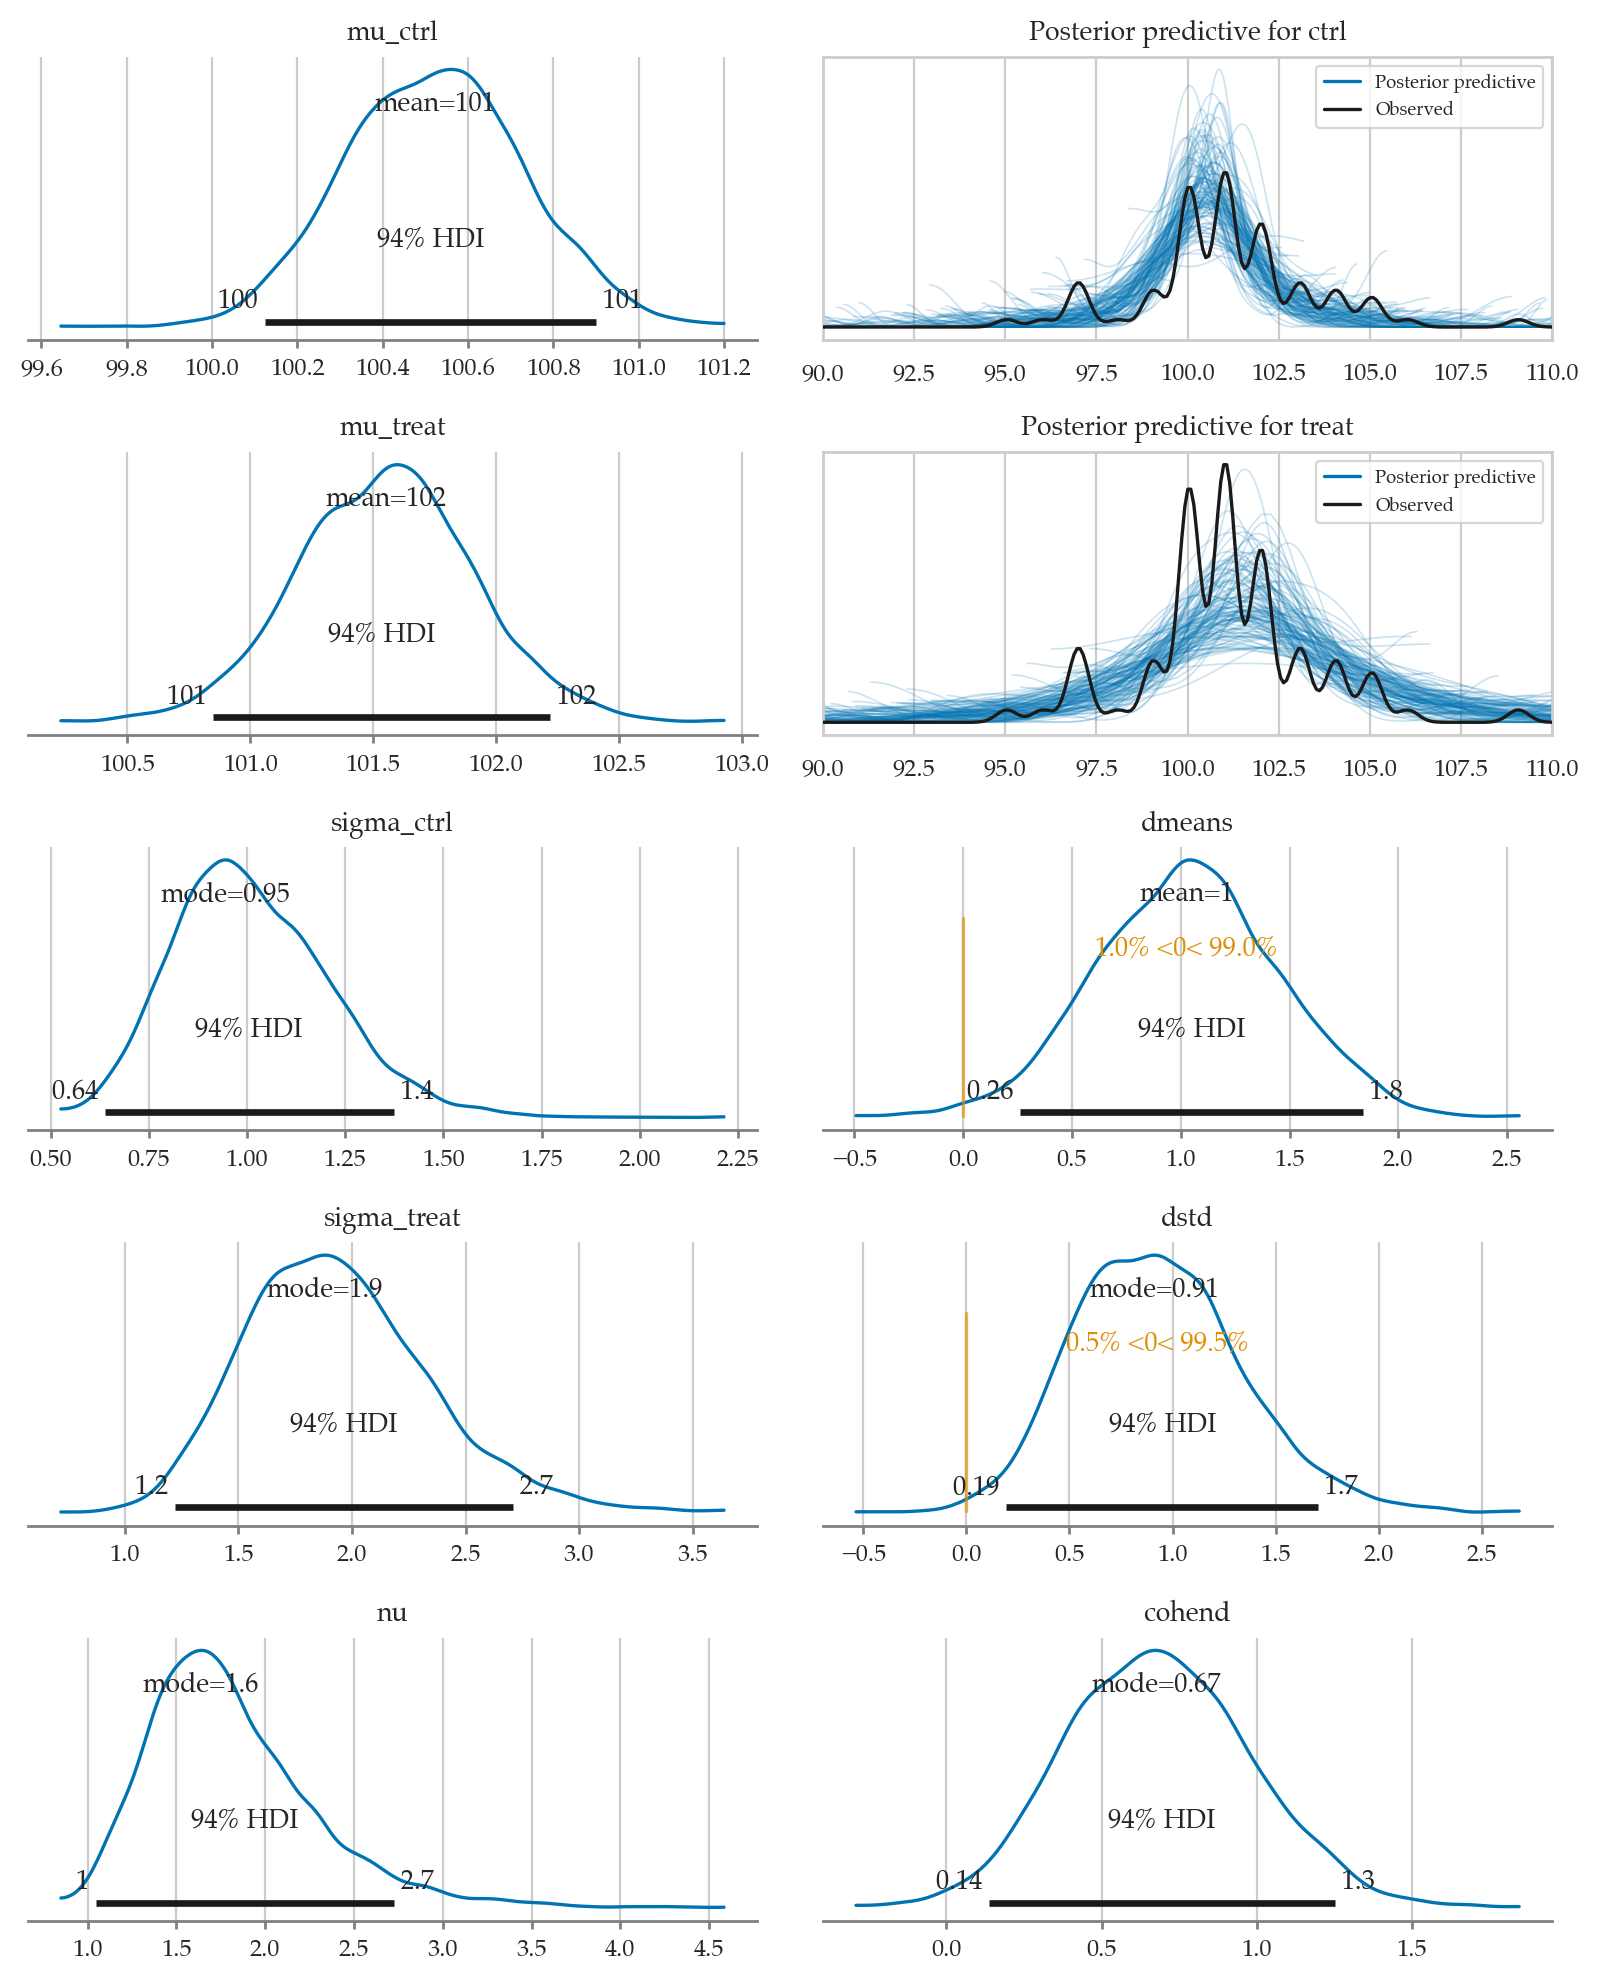

In [91]:
from ministats import plot_dmeans_stats
plot_dmeans_stats(mod3, idata3, group_name="group", ppc_xlims=[90,110]);

In [41]:
# # FIGURES ONLY
# plot_dmeans_stats(mod3, idata3, group_name="group",
#                   ppc_xlims=[90,110], figsize=(6,6.5));
# filename = os.path.join(DESTDIR, "example3_dmeans_plots.pdf")
# savefigure(plt.gcf(), filename)

### Compare to frequentist results

In [83]:
from scipy.stats import ttest_ind

treated = iqs2[iqs2["group"]=="treat"]["iq"].values
controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values

res3 = ttest_ind(treated, controls, equal_var=False)
res3.statistic, res3.pvalue

(1.622190457290228, 0.10975381983712836)

In [84]:
from ministats import cohend2
cohend2(treated, controls)

0.3309654530139732

In [86]:
# MAYBE
# # Test if the variances of the two groups are the same
# from scipy.stats import levene
# levene(treated, controls)

### Conclusions

## Explanations


### Alternative choices of priors
e.g. prior for sigma as very wiiiiiide, and  nu ~ Exp(1/29)+1 → BEST
Bayesian estimation supersedes the t-test by John K. Kruschke
- https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf 
- https://www.sumsar.net/blog/2013/06/best-online/ 

If we use a model with common standard deviation, we get equivalent of pooled sigma


### Sensitivity analysis and robustness checks

In [44]:
# TODO

## Performance tests

### Simulated datasets

Simulate data grid consisting of ∆ * outliers * n * m

### Model comparisons

Compare results several models:
- N model
- T model (robust)
- BayesFactor based on JZS prior
- Classical two-sample t-test (from Section 4.5)


## Discussion

### Comparison to the frequentist two-sample t-test

- results numerically similar
- note we're using 𝒯 as data model, not as a sampling distribution
- conceptually different:
  - p-value vs. decision based on posterior distribution
  - confidence intervals vs. credible intervals

### Comparing multiple groups

- ?Extension to Bayesian ANOVA? Can extend approach to multiple groups: Bayesian ANOVA

FWD reference to hierarchical models for group comparison covered in Section 5.5


## Exercises

### Exercise 1: small samples

In [45]:
As = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
Bs = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]
groups = ["A"]*len(As) + ["B"]*len(Bs)
df1 = pd.DataFrame({"group": groups, "vals": As + Bs})
# df1

### Exercise 2: redo exercises from Section 3.5 section using Bayesian methods

In [46]:
# TODO

## Links

# BONUS Examples

## Example 4: small example form BEST vignette

See http://cran.nexr.com/web/packages/BEST/vignettes/BEST.pdf#page=2


In [47]:
y1s = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
y2s = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]

from ministats.bayes import bayes_dmeans
mod4, idata4 = bayes_dmeans(y1s, y2s, groups=["y1", "y2"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [48]:
from ministats import calc_dmeans_stats
calc_dmeans_stats(idata4)
az.summary(idata4, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_y1", "sigma_y2", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-1.447,0.508,-2.405,-0.381
sigma_y1,0.857,0.336,0.348,1.511
sigma_y2,0.726,0.287,0.316,1.278
dstd,-0.131,0.445,-1.089,0.708
nu,21.487,14.237,1.394,49.291
cohend,-1.903,0.776,-3.443,-0.376


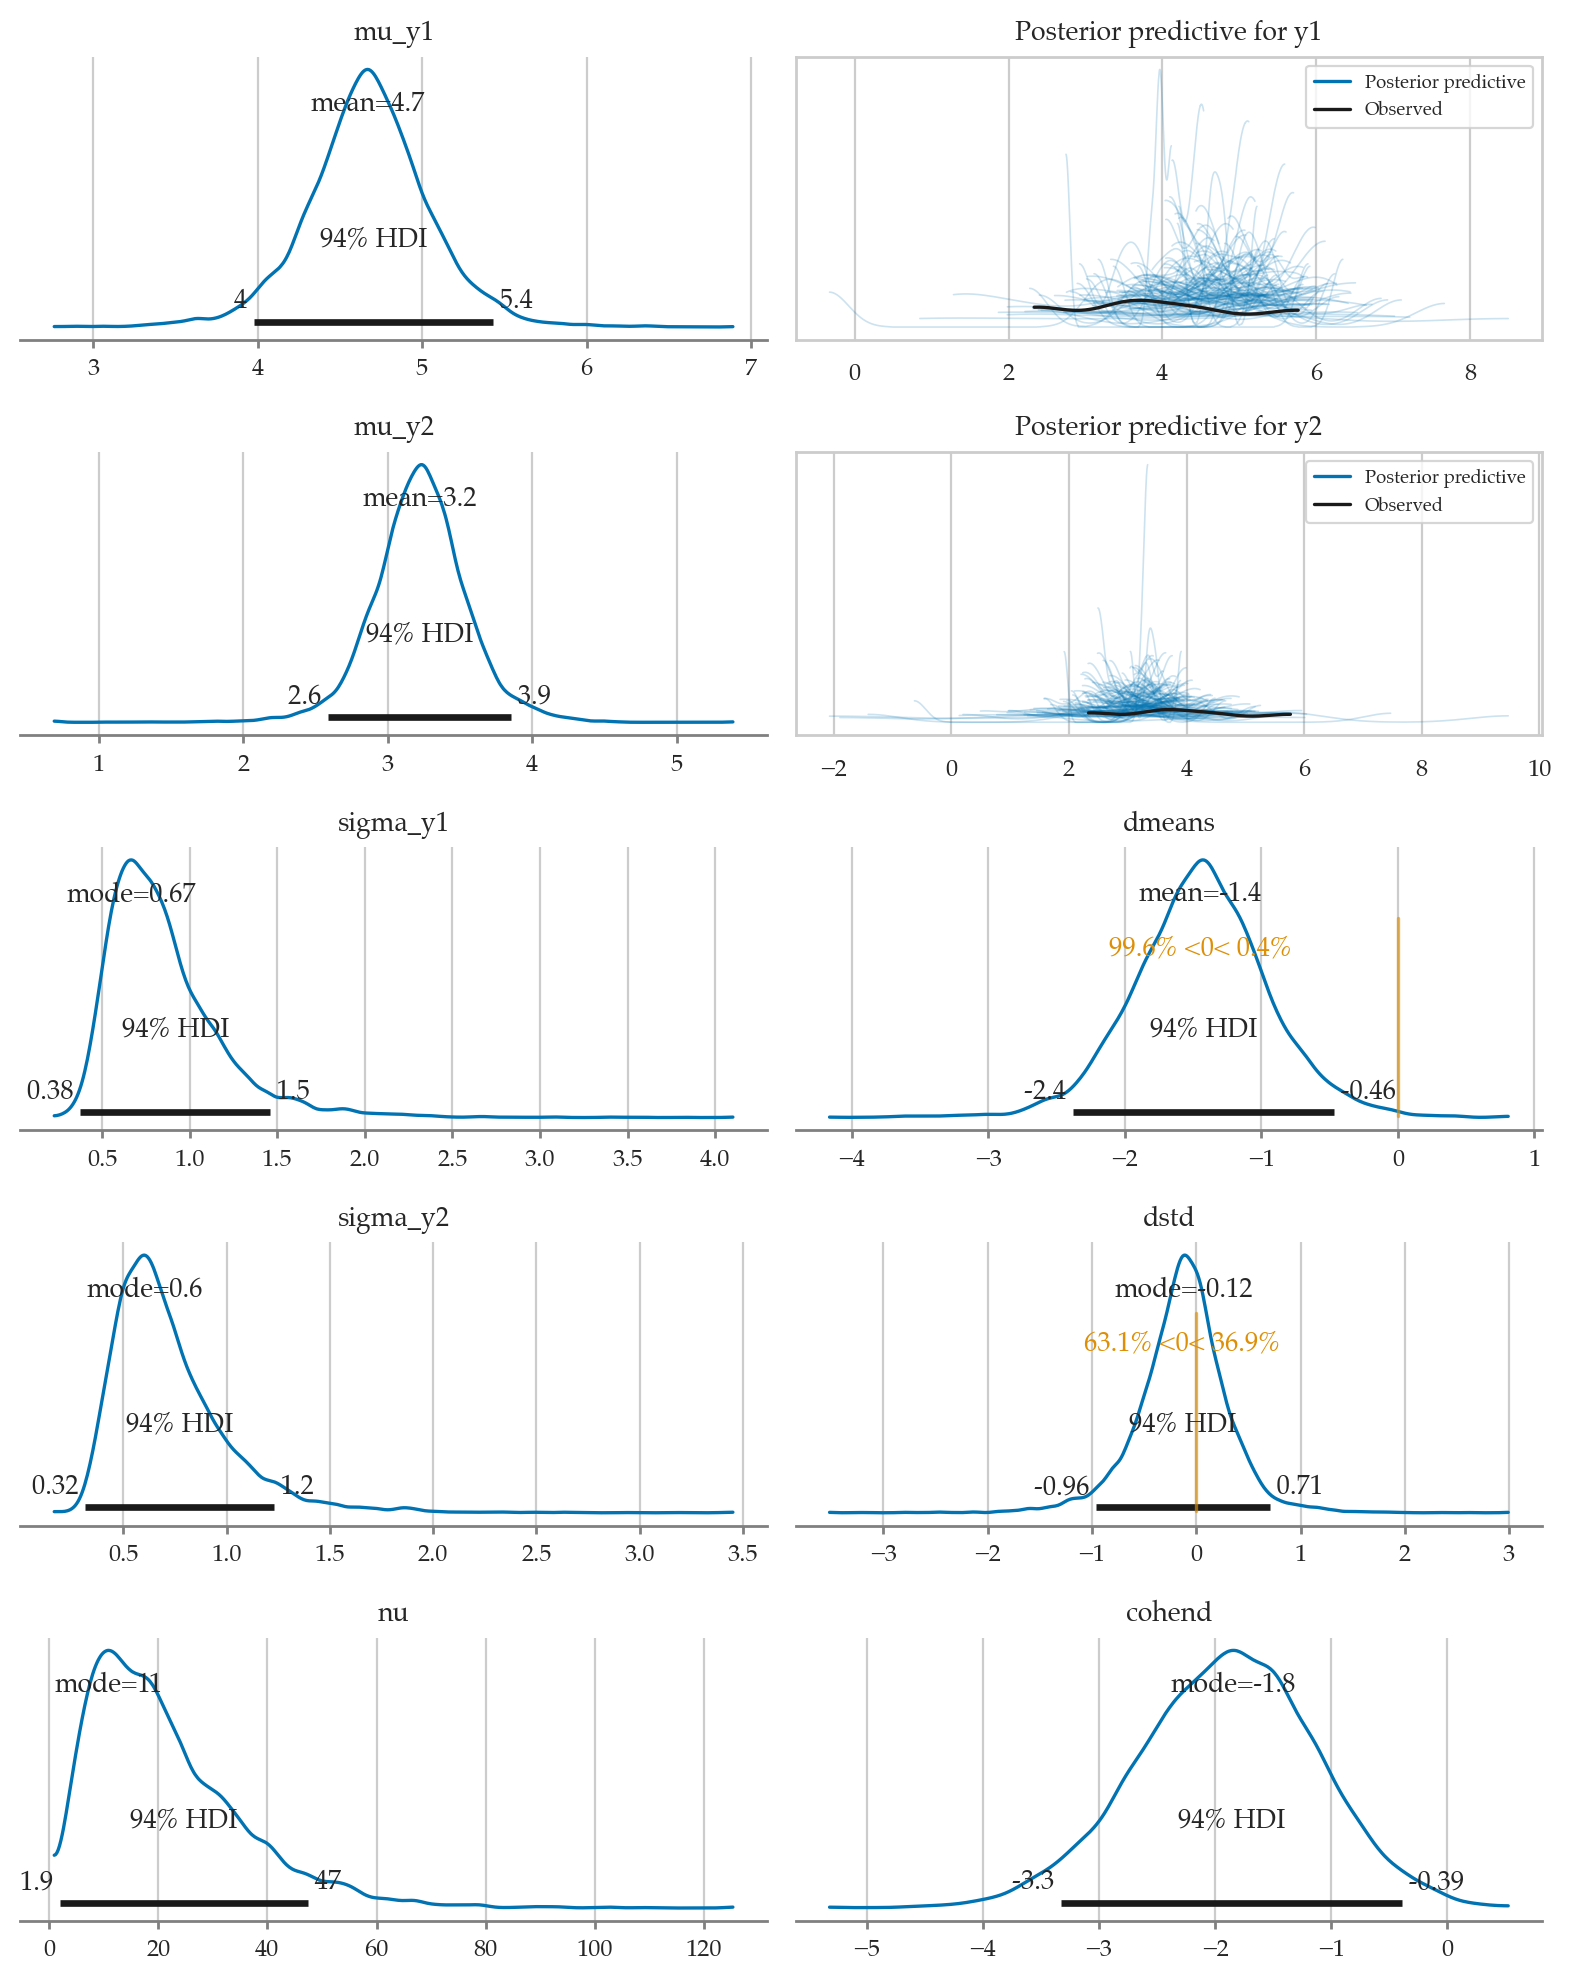

In [49]:
from ministats import plot_dmeans_stats
plot_dmeans_stats(mod4, idata4, ppc_xlims=None);

## Example 5: comparing morning to evening

https://github.com/treszkai/best/blob/master/examples/paired_samples.py


In [50]:
morning = [8.99, 9.21, 9.03, 9.15, 8.68, 8.82, 8.66, 8.82, 8.59, 8.14,
           9.09, 8.80, 8.18, 9.23, 8.55, 9.03, 9.36, 9.06, 9.57, 8.38]
evening = [9.82, 9.34, 9.73, 9.93, 9.33, 9.41, 9.48, 9.14, 8.62, 8.60,
           9.60, 9.41, 8.43, 9.77, 8.96, 9.81, 9.75, 9.50, 9.90, 9.13]

In [51]:
from ministats.bayes import bayes_dmeans
mod5, idata5 = bayes_dmeans(evening, morning, groups=["evening", "morning"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [52]:
from ministats import calc_dmeans_stats
calc_dmeans_stats(idata5)
az.summary(idata5, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_evening", "sigma_morning", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-0.528,0.142,-0.813,-0.252
sigma_evening,0.456,0.086,0.306,0.625
sigma_morning,0.390,0.073,0.257,0.533
dstd,-0.066,0.111,-0.288,0.151
nu,22.964,14.027,3.091,50.864
cohend,-1.260,0.379,-2.024,-0.547


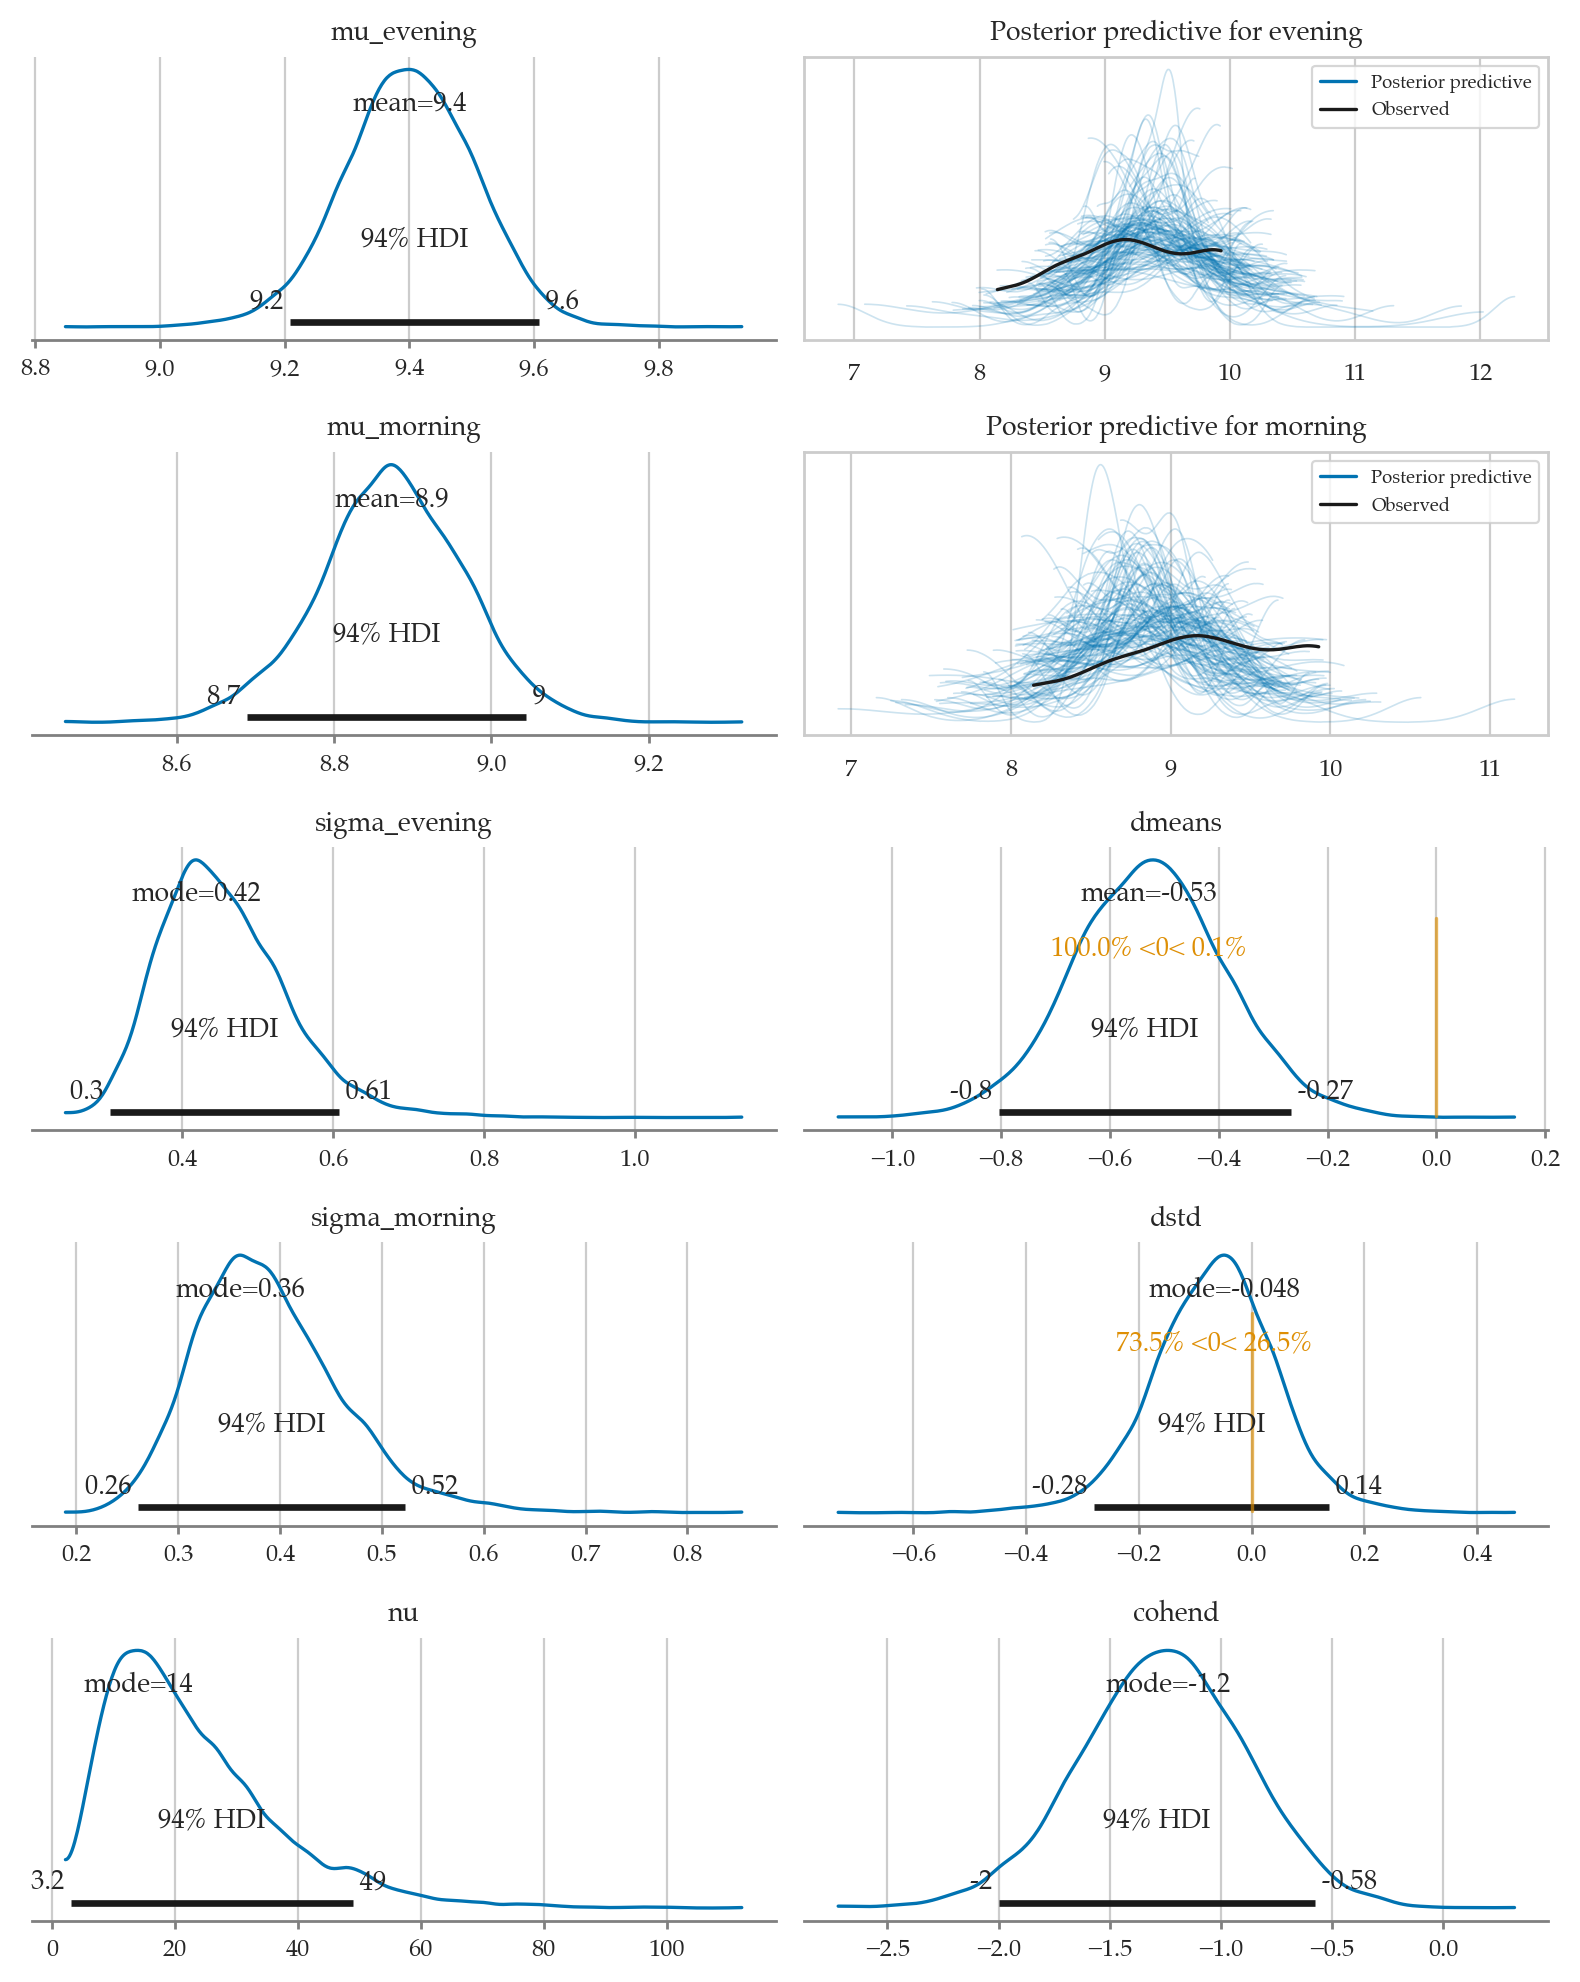

In [53]:
from ministats import plot_dmeans_stats
plot_dmeans_stats(mod5, idata5, ppc_xlims=None);